In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    i_left = 0
    i_right = 0
    j_down = 0
    j_up = 0
    while (i_search - i_left >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search - i_left, j_search], lon_rho[i_search - i_left, j_search])) < SEARCH_WIDTH/2:
        i_left += 1
    while (i_search + i_right < lon_rho.shape[0] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search + i_right, j_search], lon_rho[i_search + i_right, j_search])) < SEARCH_WIDTH/2:
        i_right += 1
    while (j_search - j_down >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search, j_search - j_down], lon_rho[i_search, j_search - j_down])) < SEARCH_WIDTH/2:
        j_down += 1
    while (j_search + j_up < lon_rho.shape[1] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search, j_search + j_up], lon_rho[i_search, j_search + j_up])) < SEARCH_WIDTH/2:
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_up = min(j_search + j_up, lon_rho.shape[1])
    j_down = max(j_search - j_down + 1, 0)

    return i_left, i_right, j_down, j_up

edata = eddies['Eddy15'].iloc[5]
t = extract_number(edata.name)

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    vort = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy') 
    previous_file_idx = file_idx

## MC METHOD

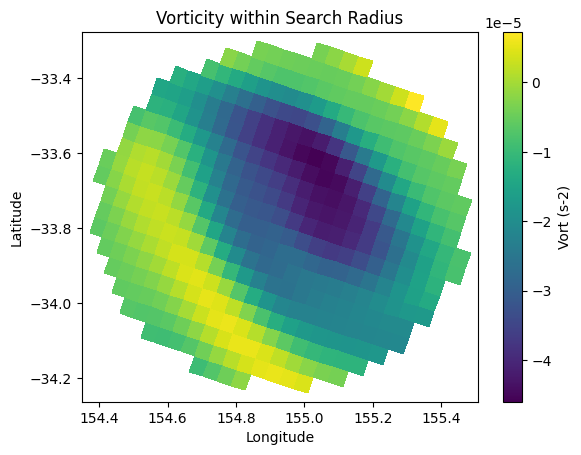

In [4]:
surf_lon = edata.Lon
surf_lat = edata.Lat
R = distance(edata.Lat, edata.Lon, lat_rho, lon_rho)
mask = R < 50000 #m
vort_masked = np.where(mask, vort[:,:,15, t_mod], np.nan) 
plt.pcolormesh(lon_rho, lat_rho, vort_masked)
plt.colorbar(label='Vort (s-2)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vorticity within Search Radius')
plt.xlim([np.nanmin(np.where(mask,lon_rho,np.nan))-0.05,np.nanmax(np.where(mask,lon_rho,np.nan))+0.05])
plt.ylim([np.nanmin(np.where(mask,lat_rho,np.nan))-0.05,np.nanmax(np.where(mask,lat_rho,np.nan))+0.05])
plt.show()

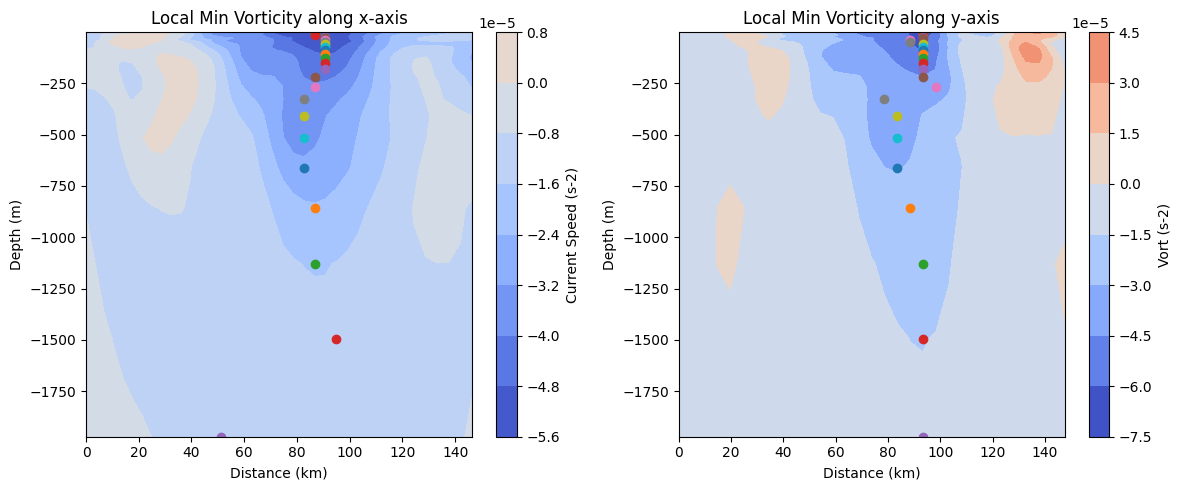

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

SEARCH_WIDTH = 150000
depth_lvl_limit = 25

# First subplot
i_left, i_right, _, _ = grid_finder(i_search, j_search, SEARCH_WIDTH)

vort_cross = vort[i_left:i_right, j_search, :depth_lvl_limit, t_mod] 
data_range = np.nanmax(np.abs(vort_cross))
x = distance(lat_rho[i_left, j_search], lon_rho[i_left, j_search], lat_rho[i_left:i_right, j_search], lon_rho[i_left:i_right, j_search])/1000
z = z_r[150, 150, :depth_lvl_limit]

X, Z = np.meshgrid(x, z)

c1 = axs[0].contourf(X, Z, vort_cross.T, cmap=plt.get_cmap('coolwarm'), vmin=-data_range, vmax=data_range)
axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Local Min Vorticity along x-axis')
fig.colorbar(c1, ax=axs[0], label='Current Speed (s-2)')

max_indices = np.nanargmin(vort_cross, axis=0)
for r, max_index in enumerate(max_indices):
    axs[0].scatter(x[max_index], z[r])

# Second subplot
_, _, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

vort_cross = vort[i_search, j_down:j_up, :depth_lvl_limit, t_mod] 
data_range = np.nanmax(np.abs(vort_cross))
y = distance(lat_rho[i_search, j_down], lon_rho[i_search, j_down], lat_rho[i_search, j_down:j_up], lon_rho[i_search, j_down:j_up])/1000
z = z_r[150, 150, :depth_lvl_limit]

Y, Z = np.meshgrid(y, z)

c2 = axs[1].contourf(Y, Z, vort_cross.T, cmap=plt.get_cmap('coolwarm'), vmin=-data_range, vmax=data_range)
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('Local Min Vorticity along y-axis')
fig.colorbar(c2, ax=axs[1], label='Vort (s-2)')

min_indices = np.nanargmin(vort_cross, axis=0)
for r, min_index in enumerate(min_indices):
    axs[1].scatter(y[min_index], z[r])

plt.tight_layout()
plt.show()

In [22]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

def IsContourConvex(xt, yt, DeficiencyThresh):
    # The DeficiencyThresh parameter represents a threshold percentage
    #  that determines how close the shape is to being convex. It compares
    #  the area of the convex hull (the smallest convex shape that can contain
    #  all the points) to the area of the original shape formed by the points.
    # Combine xt and yt into a list of (x, y) points
    points = list(zip(xt, yt))
    # Compute the convex hull
    hull = ConvexHull(points, qhull_options='QJ')
    # Calculate the area of the convex hull
    HullArea = hull.volume  # In 2D, volume is the area
    # Calculate the area of the original polygon
    polygon = Polygon(points)
    Area = polygon.area
    # Compute the area deficiency
    AreaDeficiency = abs(HullArea - Area) / Area * 100
    # Check if the area deficiency is within the threshold
    if AreaDeficiency <= DeficiencyThresh:
        flag = True
    else:
        flag = False
    return flag

def IsContourClosed(xt, yt):
    if len(xt) < 3 or len(yt) < 3:
        return False
    if xt[0] == xt[-1] and yt[0] == yt[-1]:
        return True
    else:
        return False

def find_local_minima(matrix):
    def is_local_minima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_less_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor < value
        
        if i > 0 and is_valid_and_less_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_less_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_less_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_less_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_less_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_less_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_less_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_less_than(value, matrix[i + 1, j + 1]):
            return False
        return True

    i_min = []
    j_min = []
    value_min = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_minima(matrix, i, j):
                i_min.append(i)
                j_min.append(j)
                value_min.append(matrix[i,j])
    return i_min, j_min, value_min

from shapely.geometry import Point, Polygon

def is_point_inside_contour(x_coords, y_coords, px, py):
    contour = Polygon(zip(x_coords, y_coords))
    point = Point(px, py)
    return contour.contains(point)

def check_points_arnt_collinear(xt, yt):
    if len(xt) < 3 or len(yt) < 3:
        return False
        
    points = np.column_stack((xt, yt))
    ref_point = points[0]
    diffs = points - ref_point
    
    for i in range(1, len(diffs) - 1):
        det = diffs[i][0] * diffs[i+1][1] - diffs[i][1] * diffs[i+1][0]
        if not np.isclose(det, 0):
            return True
        
    return False

# from shapely.geometry import Polygon
# def smallest_contour(x, y):
#     min_area = float('inf')
#     xt, yt = [], []
#     for xi, yi in zip(x, y):
#         polygon = Polygon(zip(xi, yi))
#         area = polygon.area
#         if area < min_area:
#             min_area = area
#             xt, yt = xi, yi

#     return xt, yt

def calculate_area(x, y):
    # Ensure the polygon is closed by repeating the first point at the end
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    
    # Shoelace formula
    area = 0.5 * np.abs(np.sum(x[:-1] * y[1:] - x[1:] * y[:-1]))
    return area

import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

from scipy.optimize import minimize
def smooth_contour(x, y, num_points, s):
    if len(x) == 0:
        return [], []

    def fit_ellipse(x, y):
    
        def ellipse_residuals(params):

            a, b, x0, y0, theta = params
            angle = np.deg2rad(theta)
            cos_t = np.cos(angle)
            sin_t = np.sin(angle)
            x_rot = (x - x0) * cos_t + (y - y0) * sin_t
            y_rot = -(x - x0) * sin_t + (y - y0) * cos_t
            return np.sum(((x_rot**2) / a**2 + (y_rot**2) / b**2 - 1) ** 2)

        # Initial guess for ellipse parameters: (a, b, x0, y0, theta)
        initial_guess = [1, 1, np.mean(x), np.mean(y), 0]
        result = minimize(ellipse_residuals, initial_guess, method='L-BFGS-B')
        return result.x

    def generate_ellipse_points(a, b, x0, y0, theta, num_points):

        t = np.linspace(0, 2 * np.pi, num_points)
        x = a * np.cos(t)
        y = b * np.sin(t)
        angle = np.deg2rad(theta)
        cos_t = np.cos(angle)
        sin_t = np.sin(angle)
        x_rot = x * cos_t - y * sin_t + x0
        y_rot = x * sin_t + y * cos_t + y0
        return x_rot, y_rot

    if len(x) == 0:
        return [], []

    if not (x[0] == x[-1] and y[0] == y[-1]):
        x = np.append(x, x[0])
        y = np.append(y, y[0])

    # Fit an ellipse to the contour
    a, b, x0, y0, theta = fit_ellipse(x, y)
    
    # Generate smoothed contour points based on the fitted ellipse
    smoothed_x, smoothed_y = generate_ellipse_points(a, b, x0, y0, theta, num_points)

    return smoothed_x, smoothed_y

def find_closest_point_index(x, y, target):
    if len(x) == 0:
        return [], []
    distances = np.sqrt((np.array(x) - target[0])**2 + (np.array(y) - target[1])**2)
    closest_index = np.argmin(distances)
    return closest_index

from scipy.interpolate import griddata
def max_closed_convex_contour_finder(xc, yc, x, y, Vort):   

    AREA_MINIMUM = 40 #km^2
    AREA_MAXIMUM = 3141592 # pi(1000)^2    137395233
    NUM_POINTS_CONTOUR = 50

    X, Y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
    Z = griddata((x, y), Vort, (X, Y), method='linear')

        
    data_range = np.nanmax(Z) - np.nanmin(Z)

    num_contours = 50
    xt_max = []
    yt_max = []
    for k in range(1, num_contours + 1):
        contour_lvl = np.nanmin(Z) + k*data_range/num_contours

        c = plt.contour(X, Y, Z,levels=[contour_lvl])
        plt.close()

        for level_paths in c.allsegs:

            # xt_lvl = []
            # yt_lvl = []
            for path in level_paths:
                xt = path[:, 0]
                yt = path[:, 1]

                DeficiencyThresh = 10 #1e-2
                if check_points_arnt_collinear(xt, yt):
                    if IsContourClosed(xt, yt):
                        if IsContourConvex(xt, yt, DeficiencyThresh) and is_point_inside_contour(xt, yt, xc, yc):
                            if calculate_area(xt, yt) > AREA_MINIMUM:
                                # xt_lvl.append(list(xt))
                                # yt_lvl.append(list(yt))
                                xt_max = xt
                                yt_max = yt
                            
            # xt_max, yt_max = smallest_contour(xt_lvl, yt_lvl)
    xt_max, yt_max = smooth_contour(xt_max, yt_max, num_points=NUM_POINTS_CONTOUR, s=0.5)
    if len(xt_max) > 0:
        if calculate_area(xt_max, yt_max) > AREA_MAXIMUM:
            xt_max, yt_max = [], []

    df = pd.DataFrame({'xt': xt_max, 'yt': yt_max})
    return df
                        


In [23]:
SEARCH_RADIUS = 50000
surf_lon = edata.Lon
surf_lat = edata.Lat

depth_dics = {}

for depth_lvl in range(24):
    if depth_lvl == 0:
        R = np.sqrt((lon_rho - surf_lon)**2 + (lat_rho - surf_lat)**2)
    else:
        R = np.sqrt((lon_rho - c_lon)**2 + (lat_rho - c_lat)**2)

    i_search_lvl, j_search_lvl = np.argwhere(R == np.min(R))[0]
    
    R = distance(lat_rho[i_search_lvl, j_search_lvl], lon_rho[i_search_lvl, j_search_lvl], lat_rho, lon_rho)
    mask = R < SEARCH_RADIUS
    
    vort_masked = np.where(mask, vort[:,:,depth_lvl, t_mod], np.nan) 
    if np.any(np.isfinite(vort_masked)):
        ic, jc = np.unravel_index(np.nanargmin(vort_masked), vort_masked.shape)
        ic, jc = int(ic), int(jc)
    
        ix, jy = np.where(mask == True)
        df = pd.DataFrame({
            'i': ix,
            'j': jy,
            'Vort': vort_masked[ix,jy]
        })
    
        depth = float(z_r[150,150,depth_lvl])
    
        depth_dics['Depth'+str(depth_lvl)] = {'df': df, 'ic': ic, 'jc': jc, 'Depth': depth}
    
        c_lon = lon_rho[ic, jc]
        c_lat = lat_rho[ic, jc]

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

theta0 = np.deg2rad(edata.Lon)
phi0 = np.deg2rad(edata.Lat)

for depth_dic in depth_dics:
    
    ix = depth_dics[depth_dic]['df'].i
    jy = depth_dics[depth_dic]['df'].j
    ic = depth_dics[depth_dic]['ic']
    jc = depth_dics[depth_dic]['jc']
    
    lons = lon_rho[ix, jy]
    lats = lat_rho[ix, jy]
    lonc = lon_rho[ic, jc]
    latc = lat_rho[ic, jc]
    
    lonr = np.deg2rad(lons)
    latr = np.deg2rad(lats)
    r_earth = 6371
    x = r_earth * np.cos(phi0) * (lonr - theta0)
    y = r_earth * (latr - phi0)
    
    xc = r_earth * np.cos(phi0) * (np.deg2rad(lonc) - theta0)
    yc = r_earth * (np.deg2rad(latc) - phi0)

    depth_dics[depth_dic]['df']['x'] = x
    depth_dics[depth_dic]['df']['y'] = y
    depth_dics[depth_dic]['xc'] = float(xc)
    depth_dics[depth_dic]['yc'] = float(yc)

for depth_dic in depth_dics:
    Vort = depth_dics[depth_dic]['df']['Vort']
    x = depth_dics[depth_dic]['df'].x
    y = depth_dics[depth_dic]['df'].y
    xc = depth_dics[depth_dic]['xc']
    yc = depth_dics[depth_dic]['yc']
    depth_dics[depth_dic]['Contour'] = max_closed_convex_contour_finder(xc, yc, x, y, Vort)

/scratch/pbs.5639876.kman.restech.unsw.edu.au/ipykernel_86125/836527922.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


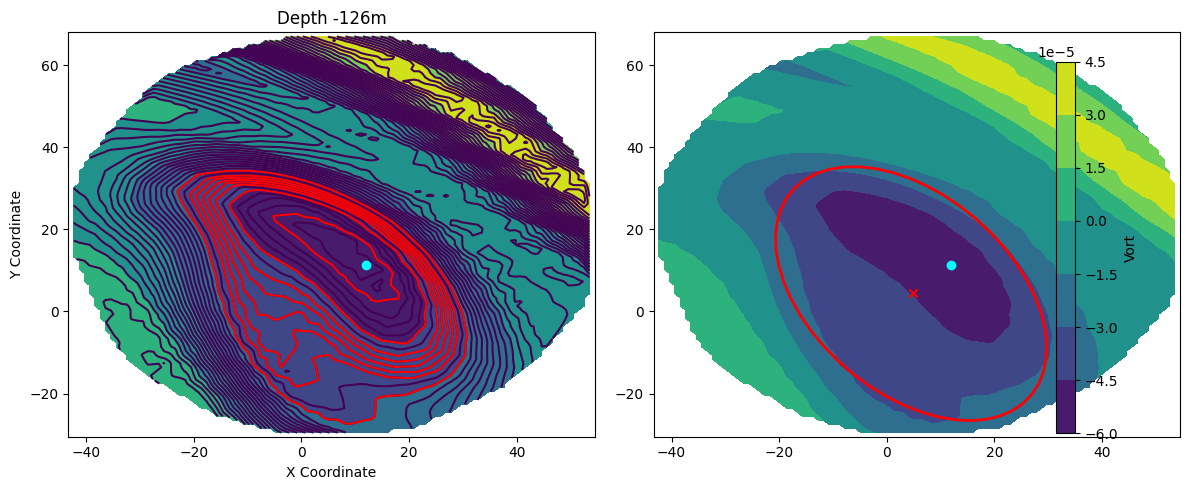

In [24]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

depth_dic = 'Depth12'

Vort = depth_dics[depth_dic]['df']['Vort']
x = depth_dics[depth_dic]['df'].x
y = depth_dics[depth_dic]['df'].y
xc = depth_dics[depth_dic]['xc']
yc = depth_dics[depth_dic]['yc']
d = depth_dics[depth_dic]['Depth']

X, Y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
Z = griddata((x, y), Vort, (X, Y), method='linear')

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

# First plot
contourf1 = axs[0].contourf(X, Y, Z, cmap='viridis')
axs[0].set_title('Depth ' + str(round(d)) + 'm')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')

data_range = np.nanmax(Z) - np.nanmin(Z)
num_contours = 50
for k in range(1, num_contours + 1):
    contour_lvl = np.nanmin(Z) + k * data_range / num_contours
    c = axs[0].contour(X, Y, Z, levels=[contour_lvl])
    for level_paths in c.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            DeficiencyThresh = 10
            if IsContourClosed(xt, yt):
                if IsContourConvex(xt, yt, DeficiencyThresh) and is_point_inside_contour(xt, yt, xc, yc):
                    axs[0].plot(xt, yt, color='red')

axs[0].scatter(xc, yc, marker='o', color='cyan')

# Second plot
contourf2 = axs[1].contourf(X, Y, Z, cmap='viridis')
axs[1].scatter(xc, yc, marker='o', color='cyan')

contour_data = depth_dics[depth_dic]['Contour']
xt = contour_data.xt
yt = contour_data.yt

axs[1].plot(xt, yt, linewidth=2, color='red')
axs[1].scatter(np.nanmean(xt), np.nanmean(yt), marker='x', color='r')

# Add colorbar
cbar = fig.colorbar(contourf2, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Vort')

plt.tight_layout()
plt.show()


/scratch/pbs.5639876.kman.restech.unsw.edu.au/ipykernel_86125/364188605.py:23: RuntimeWarning: Mean of empty slice
  xtc.append(np.nanmean(xt))
/scratch/pbs.5639876.kman.restech.unsw.edu.au/ipykernel_86125/364188605.py:24: RuntimeWarning: Mean of empty slice
  ytc.append(np.nanmean(yt))
/scratch/pbs.5639876.kman.restech.unsw.edu.au/ipykernel_86125/364188605.py:25: RuntimeWarning: Mean of empty slice
  ax1.scatter(np.nanmean(xt), np.nanmean(yt), depth, color='k', marker='x')


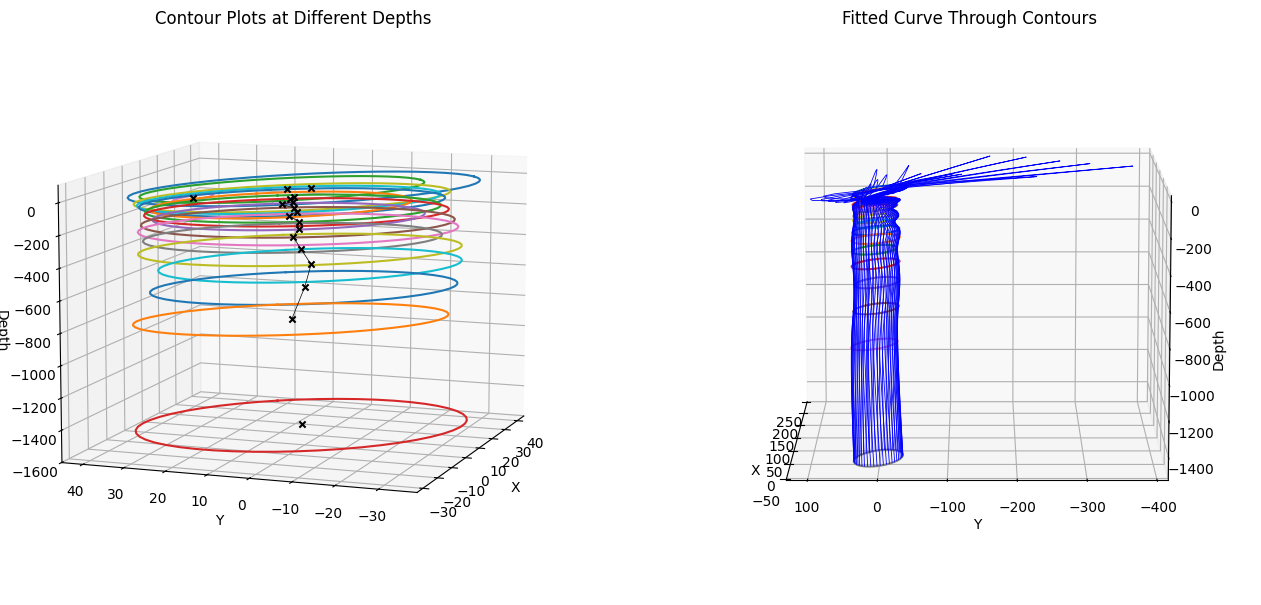

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import numpy as np

# First, prepare the figure with subplots
fig = plt.figure(figsize=(16, 12))

# First subplot (original contours at different depths)
ax1 = fig.add_subplot(121, projection='3d')

xtc = []
ytc = []
d = []
for depth_dic in depth_dics:
    depth = depth_dics[depth_dic]['Depth']
    d.append(depth)
    contour_data = depth_dics[depth_dic]['Contour']
    xt = contour_data.xt
    yt = contour_data.yt
    ax1.plot(xt, yt, [depth]*len(xt))

    xtc.append(np.nanmean(xt))
    ytc.append(np.nanmean(yt))
    ax1.scatter(np.nanmean(xt), np.nanmean(yt), depth, color='k', marker='x')
ax1.plot(xtc, ytc, d, color='k', linewidth=.5)

ax1.view_init(elev=10, azim=200)
ax1.set_title('Contour Plots at Different Depths')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Depth')

# Second subplot (fitted curve along the contours)
ax2 = fig.add_subplot(122, projection='3d')

NUM_POINTS_CONTOUR = 50
closest_index = [0] * len(depth_dics)

for t in range(NUM_POINTS_CONTOUR):
    x = []
    y = []
    z = []
    closest_index = [(value + 1) % NUM_POINTS_CONTOUR for value in closest_index]
    
    for i, depth_dic in enumerate(depth_dics):
        depth = depth_dics[depth_dic]['Depth']
        contour_data = depth_dics[depth_dic]['Contour']
        xt = contour_data.xt
        yt = contour_data.yt

        if len(xt) > 0:
            if t == 0:
                closest_index[i] = find_closest_point_index(xt, yt, (-40, -20))
                
            xp = xt[closest_index[i]]
            yp = yt[closest_index[i]]
            
            x.append(xp)
            y.append(yp)
            z.append(depth)

            if t == 0:
                ax2.plot(xt, yt, [depth]*len(xt))
    
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    # Sort the points by z-coordinate (assuming vertical alignment)
    indices = np.argsort(z)
    x_sorted = x[indices]
    y_sorted = y[indices]
    z_sorted = z[indices]

    # Fit a B-spline curve
    t = np.linspace(0, 1, len(z_sorted))  # Parameter t ranges from 0 to 1
    spline_x = UnivariateSpline(t, x_sorted, k=3)  # k=3 for cubic spline
    spline_y = UnivariateSpline(t, y_sorted, k=3)
    spline_z = UnivariateSpline(t, z_sorted, k=3)

    # Generate new points along the curve
    t_new = np.linspace(0, 1, 100)
    x_new = spline_x(t_new)
    y_new = spline_y(t_new)
    z_new = spline_z(t_new)

    # Plot original points
    # ax2.scatter(x, y, z, color='red')

    # Plot fitted curve
    ax2.plot(x_new, y_new, z_new, color='blue', linewidth=.6)

ax2.view_init(elev=10, azim=180)
ax2.set_title('Fitted Curve Through Contours')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Depth')

plt.show()



In [26]:
def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x, y

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

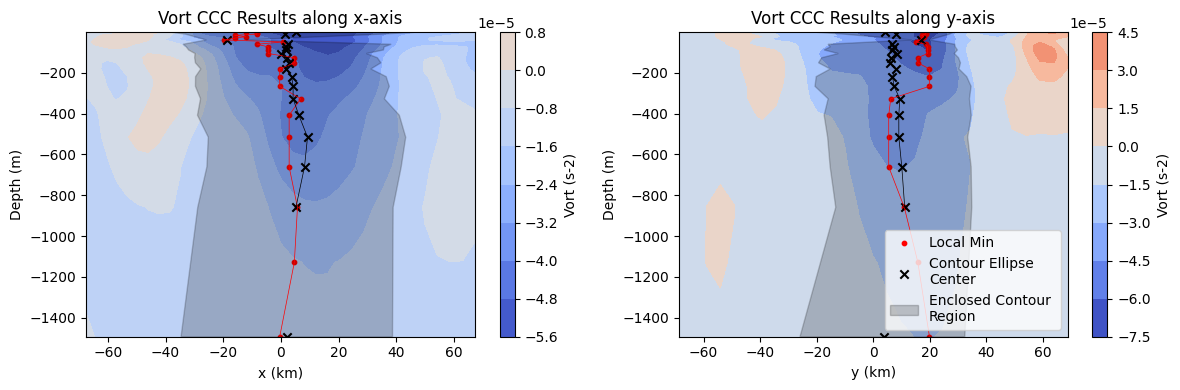

In [39]:
import matplotlib.colors as mcolors

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

DISPLAY_WIDTH = 140000
depth_lvl_limit = 24

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)

x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

x = x/1000
y = y/1000

xc_raw = []
yc_raw = []
zc = []
xt_c = []
yt_c = []
xt_mins = []
xt_maxs = []
yt_mins = []
yt_maxs = []
for depth_dic in depth_dics:
    xc_raw.append(depth_dics[depth_dic]['xc'])
    yc_raw.append(depth_dics[depth_dic]['yc'])
    zc.append(depth_dics[depth_dic]['Depth'])

    xt = depth_dics[depth_dic]['Contour'].xt
    yt = depth_dics[depth_dic]['Contour'].yt
    if len(xt) == 0:
        xt = np.nan
        yt = np.nan
    xt, yt = rotate_30_clockwise(xt, yt)
    xt_mean, yt_mean = np.mean(xt), np.mean(yt)
    xt_min, xt_max = np.min(xt), np.max(xt)
    yt_min, yt_max = np.min(yt), np.max(yt)

    xt_c.append(xt_mean)
    yt_c.append(yt_mean)
    xt_mins.append(xt_min)
    xt_maxs.append(xt_max)
    yt_mins.append(yt_min)
    yt_maxs.append(yt_max)

xc, yc = rotate_30_clockwise(xc_raw, yc_raw)

z = z_r[150, 150, :depth_lvl_limit]

x_bdry = np.concatenate((xt_mins, np.flip(xt_maxs)))
y_bdry = np.concatenate((yt_mins, np.flip(yt_maxs)))
z_bdry = np.concatenate((z, np.flip(z)))
z_bdry1 = z_bdry
x_bdry1 = x_bdry
z_bdry1 = z_bdry1[~np.isnan(x_bdry1)]
x_bdry1 = x_bdry1[~np.isnan(x_bdry1)]
z_bdry2 = z_bdry
y_bdry2 = y_bdry
z_bdry2 = z_bdry2[~np.isnan(y_bdry2)]
y_bdry2 = y_bdry2[~np.isnan(y_bdry2)]

# First subplot
vort_cross = vort[i_left:i_right, j_search, :depth_lvl_limit, t_mod]
data_range = np.nanmax(np.abs(vort_cross))

X, Z = np.meshgrid(x, z)

c1 = axs[0].contourf(X, Z, vort_cross.T, cmap='coolwarm', vmin=-data_range, vmax=data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Vort CCC Results along x-axis')
fig.colorbar(c1, ax=axs[0], label='Vort (s-2)')

axs[0].scatter(xc, zc, color='red', s=10)
axs[0].plot(xc, zc, color='red', linewidth=.5)
axs[0].scatter(xt_c, zc, marker='x', color='k')
axs[0].plot(xt_c, zc, color='k', linewidth=.5)
axs[0].fill(x_bdry1, z_bdry1, color='black', alpha=0.2)

# Second subplot
vort_cross = vort[i_search, j_down:j_up, :depth_lvl_limit, t_mod]
data_range = np.nanmax(np.abs(vort_cross))

Y, Z = np.meshgrid(y, z)

c2 = axs[1].contourf(Y, Z, vort_cross.T, cmap='coolwarm', vmin=-data_range, vmax=data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('Vort CCC Results along y-axis')
fig.colorbar(c2, ax=axs[1], label='Vort (s-2)')

m = axs[1].scatter(yc, zc, color='red', s=10)
axs[1].plot(yc, zc, color='red', linewidth=.5)
e = axs[1].scatter(yt_c, z, marker='x', color='k')
axs[1].plot(yt_c, zc, color='k', linewidth=.5)
r = axs[1].fill(y_bdry2, z_bdry2, color='black', alpha=0.2)
axs[1].legend([m, e, r[0]], ['Local Min', 'Contour Ellipse \nCenter', 'Enclosed Contour \nRegion'], loc='lower right')

plt.tight_layout()
plt.show()
